# 🔗 Intelligent Supply Chain Optimization System
## Notebook 02 — Exploratory Data Analysis (EDA)

**Project:** Intelligent Supply Chain Optimization System  
**Phase:** Exploratory Data Analysis  
**Input:** `supply_chain_validated.csv` (output from Notebook 01)  
**Objective:** Deeply understand the data through visualization and statistics before building any model.

---

### 📋 What This Notebook Does
1. Load validated dataset
2. Demand analysis — overall trends and distribution
3. Seasonality & time-series patterns
4. SKU-level demand analysis
5. Regional & warehouse analysis
6. Promotion impact analysis
7. Stockout analysis
8. Supplier & lead time analysis
9. Inventory level analysis
10. Baseline forecast quality (Demand_Forecast vs Units_Sold)
11. Correlation heatmap
12. Key findings summary

---

## 📦 Section 1: Imports & Load Data

In [1]:
# ─────────────────────────────────────────────────────────────
# SECTION 1: IMPORTS & LOAD
# ─────────────────────────────────────────────────────────────

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

plt.rcParams['figure.figsize']    = (14, 5)
plt.rcParams['axes.spines.top']   = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.titlesize']    = 13
plt.rcParams['axes.titleweight']  = 'bold'
sns.set_palette('muted')

# ── Load ──
df = pd.read_csv('D:\\6th sem\\SGP6\\cc\\supply_chain_validated.csv', parse_dates=['Date'])
df = df.sort_values(['SKU_ID', 'Warehouse_ID', 'Date']).reset_index(drop=True)

# ── Helper time columns ──
df['Month']      = df['Date'].dt.month
df['Month_Name'] = df['Date'].dt.strftime('%b')
df['DayOfWeek']  = df['Date'].dt.dayofweek          # 0=Mon
df['DayName']    = df['Date'].dt.strftime('%a')
df['Quarter']    = df['Date'].dt.quarter
df['Week']       = df['Date'].dt.isocalendar().week.astype(int)

print(f'✅ Dataset loaded: {df.shape[0]:,} rows × {df.shape[1]} columns')
print(f'   Date range   : {df["Date"].min().date()} → {df["Date"].max().date()}')

✅ Dataset loaded: 91,250 rows × 21 columns
   Date range   : 2024-01-01 → 2024-12-30


---
## 📈 Section 2: Overall Demand Trend

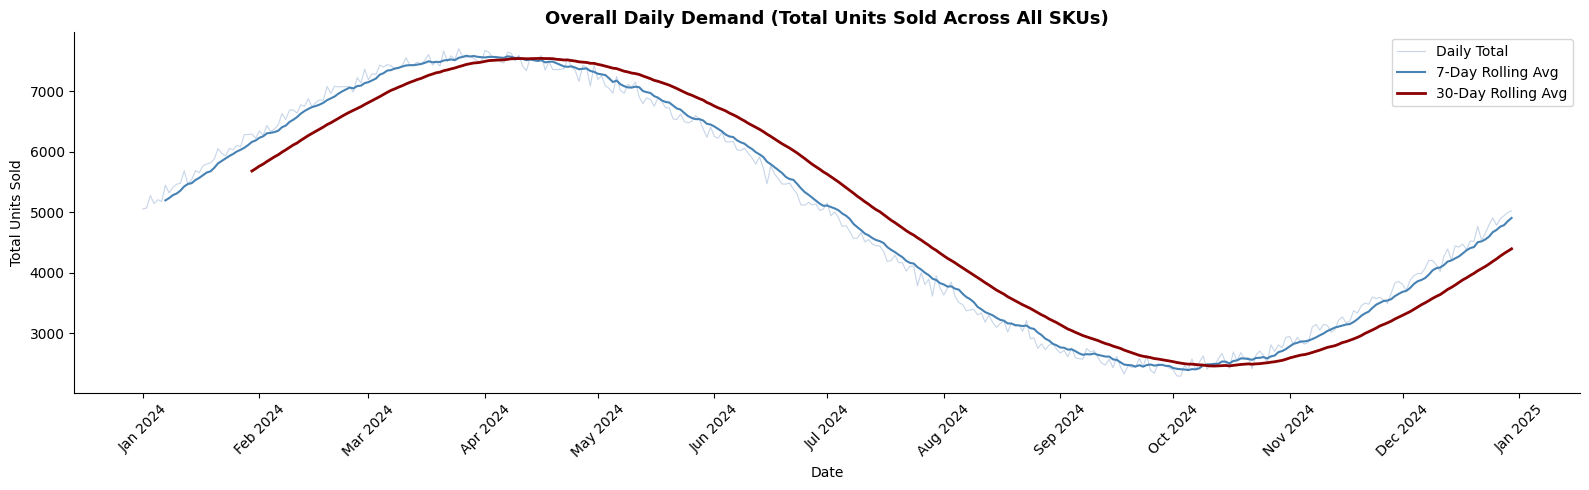

  Average daily demand : 5,013.6 units
  Peak daily demand    : 7,702 units on 2024-03-25
  Lowest daily demand  : 2,294 units on 2024-10-03


In [2]:
# ─────────────────────────────────────────────────────────────
# SECTION 2: OVERALL DEMAND TREND
# ─────────────────────────────────────────────────────────────

daily_demand = df.groupby('Date')['Units_Sold'].sum().reset_index()
daily_demand['Rolling_7']  = daily_demand['Units_Sold'].rolling(7).mean()
daily_demand['Rolling_30'] = daily_demand['Units_Sold'].rolling(30).mean()

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(daily_demand['Date'], daily_demand['Units_Sold'],
        color='lightsteelblue', linewidth=0.8, alpha=0.7, label='Daily Total')
ax.plot(daily_demand['Date'], daily_demand['Rolling_7'],
        color='steelblue', linewidth=1.5, label='7-Day Rolling Avg')
ax.plot(daily_demand['Date'], daily_demand['Rolling_30'],
        color='darkred', linewidth=2, label='30-Day Rolling Avg')
ax.set_title('Overall Daily Demand (Total Units Sold Across All SKUs)')
ax.set_xlabel('Date')
ax.set_ylabel('Total Units Sold')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

print(f'  Average daily demand : {daily_demand["Units_Sold"].mean():,.1f} units')
print(f'  Peak daily demand    : {daily_demand["Units_Sold"].max():,.0f} units on {daily_demand.loc[daily_demand["Units_Sold"].idxmax(), "Date"].date()}')
print(f'  Lowest daily demand  : {daily_demand["Units_Sold"].min():,.0f} units on {daily_demand.loc[daily_demand["Units_Sold"].idxmin(), "Date"].date()}')

---
## 🌊 Section 3: Seasonality & Time Patterns

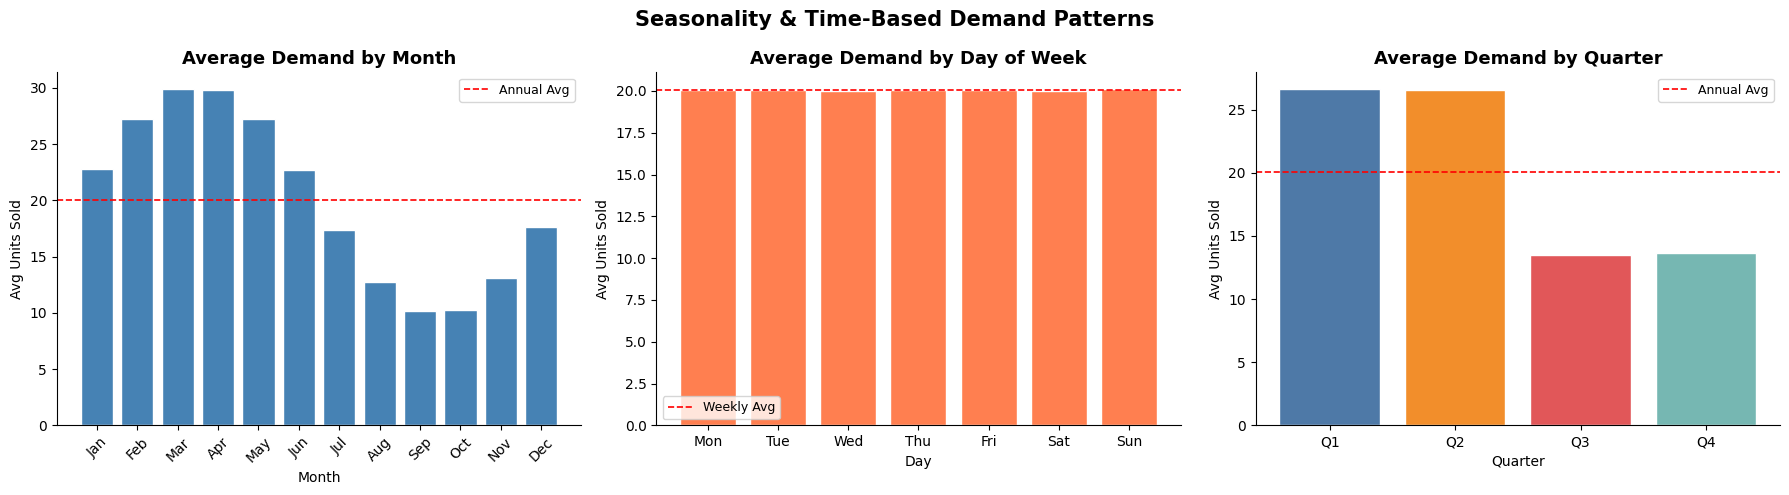

In [3]:
# ─────────────────────────────────────────────────────────────
# SECTION 3: SEASONALITY & TIME PATTERNS
# ─────────────────────────────────────────────────────────────

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ── Monthly Average Demand ──
month_order = ['Jan','Feb','Mar','Apr','May','Jun',
               'Jul','Aug','Sep','Oct','Nov','Dec']
monthly_avg = df.groupby('Month_Name')['Units_Sold'].mean().reindex(month_order)
axes[0].bar(monthly_avg.index, monthly_avg.values, color='steelblue', edgecolor='white')
axes[0].axhline(monthly_avg.mean(), color='red', linestyle='--', linewidth=1.2, label='Annual Avg')
axes[0].set_title('Average Demand by Month')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Avg Units Sold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(fontsize=9)

# ── Day of Week Pattern ──
day_order = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
dow_avg = df.groupby('DayName')['Units_Sold'].mean().reindex(day_order)
axes[1].bar(dow_avg.index, dow_avg.values, color='coral', edgecolor='white')
axes[1].axhline(dow_avg.mean(), color='red', linestyle='--', linewidth=1.2, label='Weekly Avg')
axes[1].set_title('Average Demand by Day of Week')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Avg Units Sold')
axes[1].legend(fontsize=9)

# ── Quarterly Average Demand ──
quarterly_avg = df.groupby('Quarter')['Units_Sold'].mean()
colors = ['#4e79a7','#f28e2b','#e15759','#76b7b2']
axes[2].bar([f'Q{q}' for q in quarterly_avg.index], quarterly_avg.values,
            color=colors, edgecolor='white')
axes[2].axhline(quarterly_avg.mean(), color='red', linestyle='--', linewidth=1.2, label='Annual Avg')
axes[2].set_title('Average Demand by Quarter')
axes[2].set_xlabel('Quarter')
axes[2].set_ylabel('Avg Units Sold')
axes[2].legend(fontsize=9)

plt.suptitle('Seasonality & Time-Based Demand Patterns', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

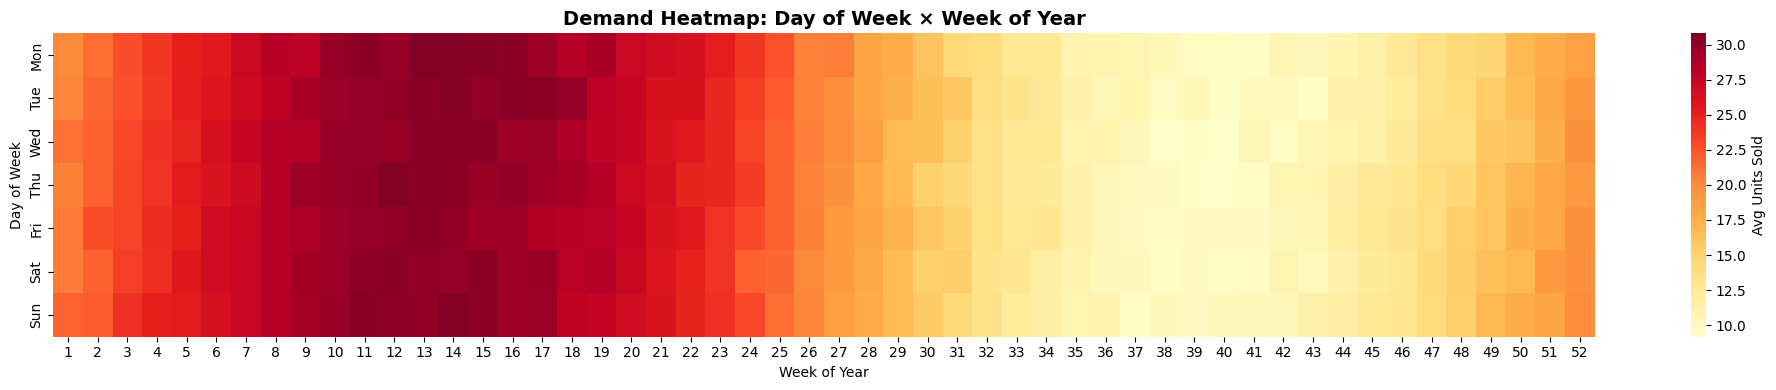

In [4]:
# ── Weekly Heatmap: Week Number × Day of Week ──
pivot_heat = df.pivot_table(values='Units_Sold', index='DayName', columns='Week', aggfunc='mean')
day_order  = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
pivot_heat = pivot_heat.reindex(day_order)

fig, ax = plt.subplots(figsize=(20, 4))
sns.heatmap(pivot_heat, cmap='YlOrRd', ax=ax, linewidths=0,
            cbar_kws={'label': 'Avg Units Sold'})
ax.set_title('Demand Heatmap: Day of Week × Week of Year', fontsize=14, fontweight='bold')
ax.set_xlabel('Week of Year')
ax.set_ylabel('Day of Week')
plt.tight_layout()
plt.show()

---
## 📦 Section 4: SKU-Level Demand Analysis

In [5]:
# ─────────────────────────────────────────────────────────────
# SECTION 4: SKU-LEVEL DEMAND ANALYSIS
# ─────────────────────────────────────────────────────────────

sku_stats = df.groupby('SKU_ID')['Units_Sold'].agg(['mean','std','sum','min','max']).round(2)
sku_stats.columns = ['Avg_Daily', 'Std_Dev', 'Total_Sold', 'Min_Daily', 'Max_Daily']
sku_stats['CV'] = (sku_stats['Std_Dev'] / sku_stats['Avg_Daily']).round(3)  # Coefficient of Variation
sku_stats = sku_stats.sort_values('Total_Sold', ascending=False)

print('── Top 10 SKUs by Total Units Sold ──')
print(sku_stats.head(10))
print()
print('── Bottom 10 SKUs by Total Units Sold ──')
print(sku_stats.tail(10))

── Top 10 SKUs by Total Units Sold ──
        Avg_Daily  Std_Dev  Total_Sold  Min_Daily  Max_Daily   CV
SKU_ID                                                           
SKU_18      20.40     9.31       37234          0         52 0.46
SKU_1       20.29     8.95       37026          0         52 0.44
SKU_33      20.28     8.98       37012          0         55 0.44
SKU_13      20.23     9.22       36915          0         54 0.46
SKU_47      20.23     8.92       36912          0         49 0.44
SKU_9       20.19     9.02       36855          0         46 0.45
SKU_4       20.17     9.15       36811          0         50 0.45
SKU_12      20.16     9.17       36794          0         54 0.46
SKU_3       20.16     9.20       36785          0         55 0.46
SKU_31      20.13     8.85       36742          0         46 0.44

── Bottom 10 SKUs by Total Units Sold ──
        Avg_Daily  Std_Dev  Total_Sold  Min_Daily  Max_Daily   CV
SKU_ID                                                        

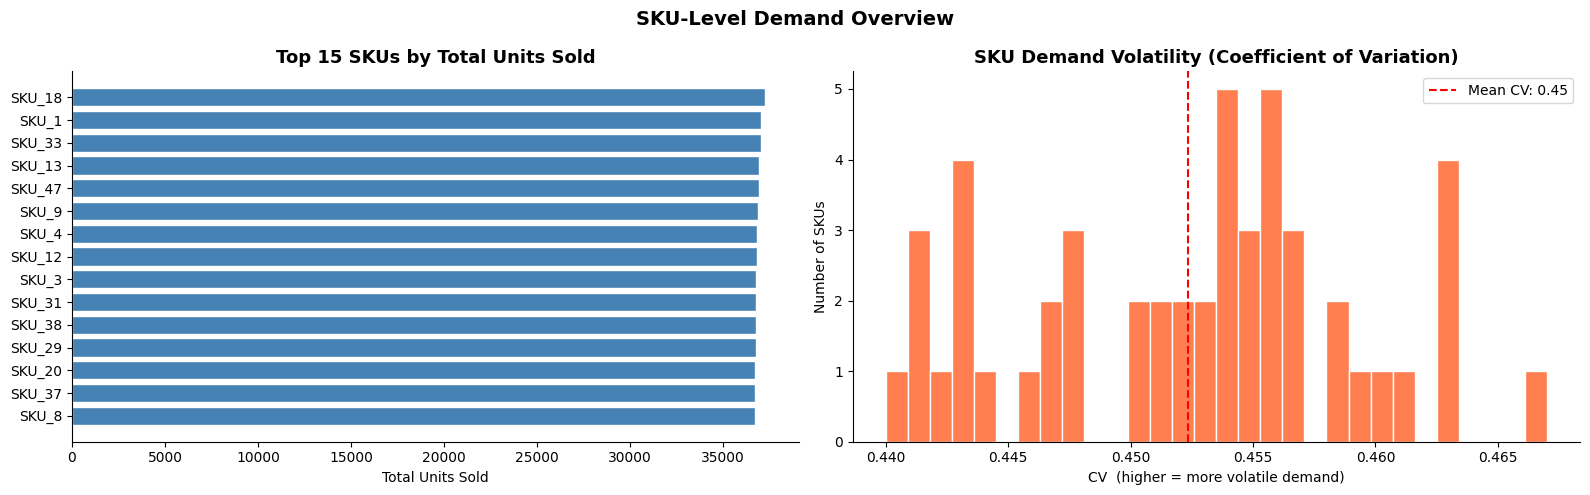


  SKUs with CV > 0.5 (high volatility) : 0
  SKUs with CV < 0.2 (stable demand)   : 0


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Top 15 SKUs by total sales
top15 = sku_stats.head(15)
axes[0].barh(top15.index[::-1], top15['Total_Sold'][::-1], color='steelblue', edgecolor='white')
axes[0].set_title('Top 15 SKUs by Total Units Sold')
axes[0].set_xlabel('Total Units Sold')

# Coefficient of Variation — demand volatility per SKU
axes[1].hist(sku_stats['CV'], bins=30, color='coral', edgecolor='white')
axes[1].axvline(sku_stats['CV'].mean(), color='red', linestyle='--',
                label=f'Mean CV: {sku_stats["CV"].mean():.2f}')
axes[1].set_title('SKU Demand Volatility (Coefficient of Variation)')
axes[1].set_xlabel('CV  (higher = more volatile demand)')
axes[1].set_ylabel('Number of SKUs')
axes[1].legend()

plt.suptitle('SKU-Level Demand Overview', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f'\n  SKUs with CV > 0.5 (high volatility) : {(sku_stats["CV"] > 0.5).sum()}')
print(f'  SKUs with CV < 0.2 (stable demand)   : {(sku_stats["CV"] < 0.2).sum()}')

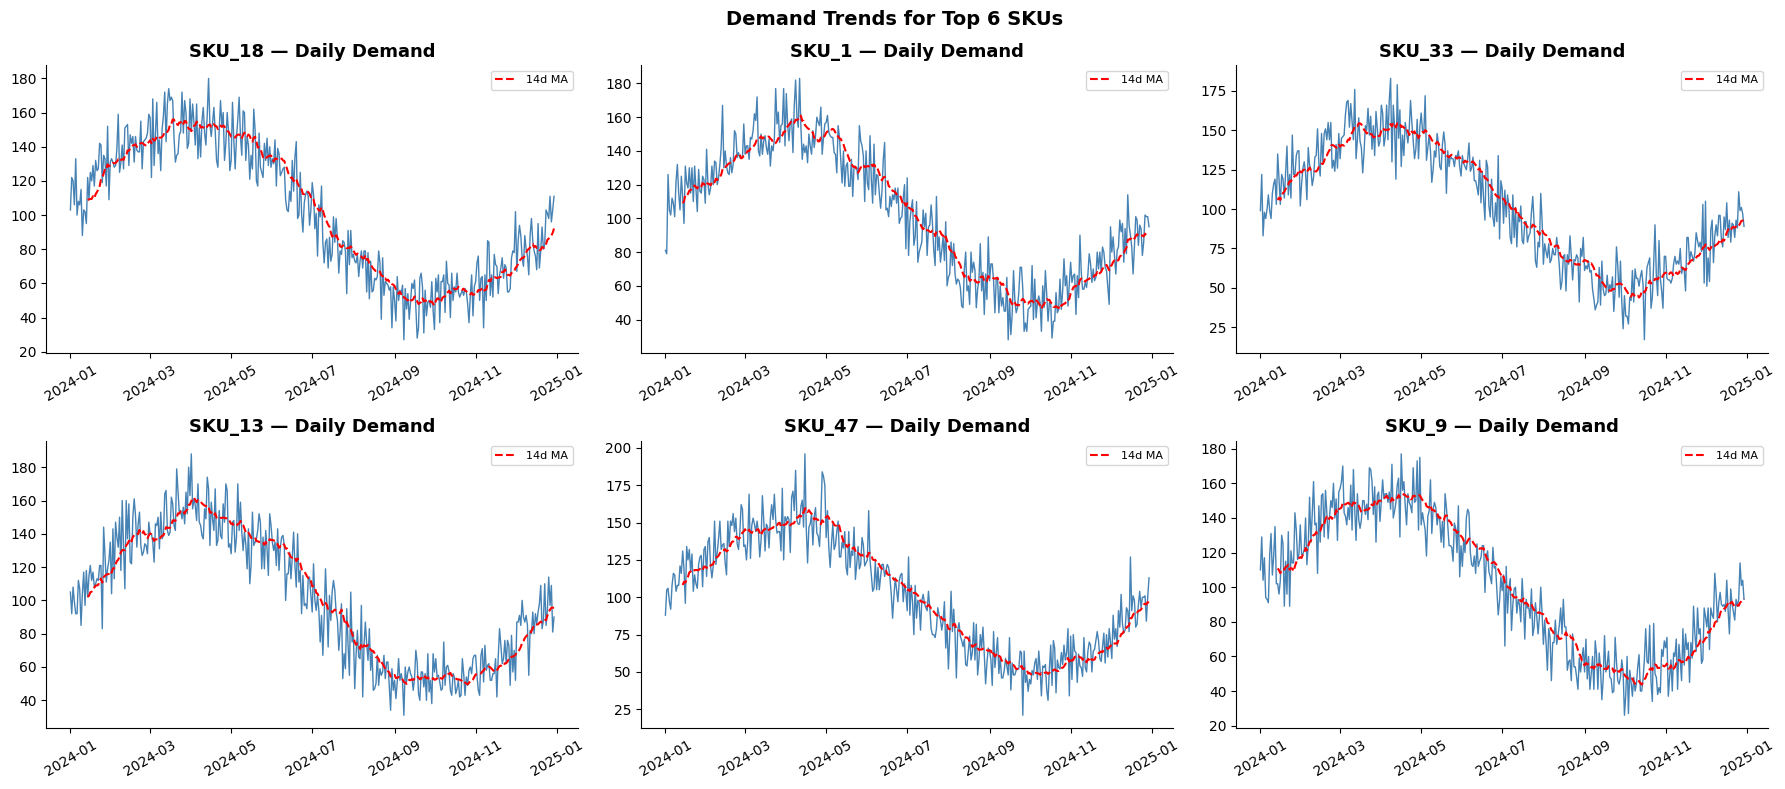

In [7]:
# Demand trend for top 6 SKUs
top6_skus = sku_stats.head(6).index.tolist()
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

for i, sku in enumerate(top6_skus):
    sku_data = df[df['SKU_ID'] == sku].groupby('Date')['Units_Sold'].sum()
    axes[i].plot(sku_data.index, sku_data.values, color='steelblue', linewidth=1)
    axes[i].plot(sku_data.index, sku_data.rolling(14).mean(),
                 color='red', linewidth=1.5, linestyle='--', label='14d MA')
    axes[i].set_title(f'{sku} — Daily Demand')
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=30)
    axes[i].legend(fontsize=8)

plt.suptitle('Demand Trends for Top 6 SKUs', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 🌍 Section 5: Regional & Warehouse Analysis

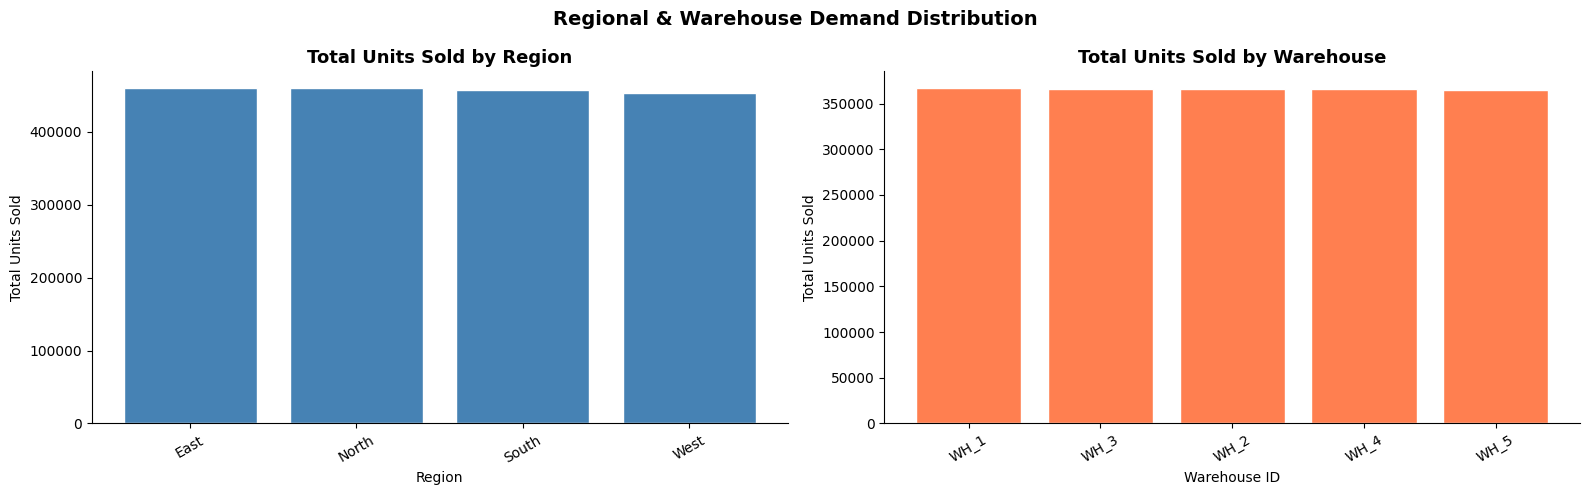

In [8]:
# ─────────────────────────────────────────────────────────────
# SECTION 5: REGIONAL & WAREHOUSE ANALYSIS
# ─────────────────────────────────────────────────────────────

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Total demand by Region
region_demand = df.groupby('Region')['Units_Sold'].sum().sort_values(ascending=False)
axes[0].bar(region_demand.index, region_demand.values, color='steelblue', edgecolor='white')
axes[0].set_title('Total Units Sold by Region')
axes[0].set_xlabel('Region')
axes[0].set_ylabel('Total Units Sold')
axes[0].tick_params(axis='x', rotation=30)

# Total demand by Warehouse
wh_demand = df.groupby('Warehouse_ID')['Units_Sold'].sum().sort_values(ascending=False)
axes[1].bar(wh_demand.index, wh_demand.values, color='coral', edgecolor='white')
axes[1].set_title('Total Units Sold by Warehouse')
axes[1].set_xlabel('Warehouse ID')
axes[1].set_ylabel('Total Units Sold')
axes[1].tick_params(axis='x', rotation=30)

plt.suptitle('Regional & Warehouse Demand Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

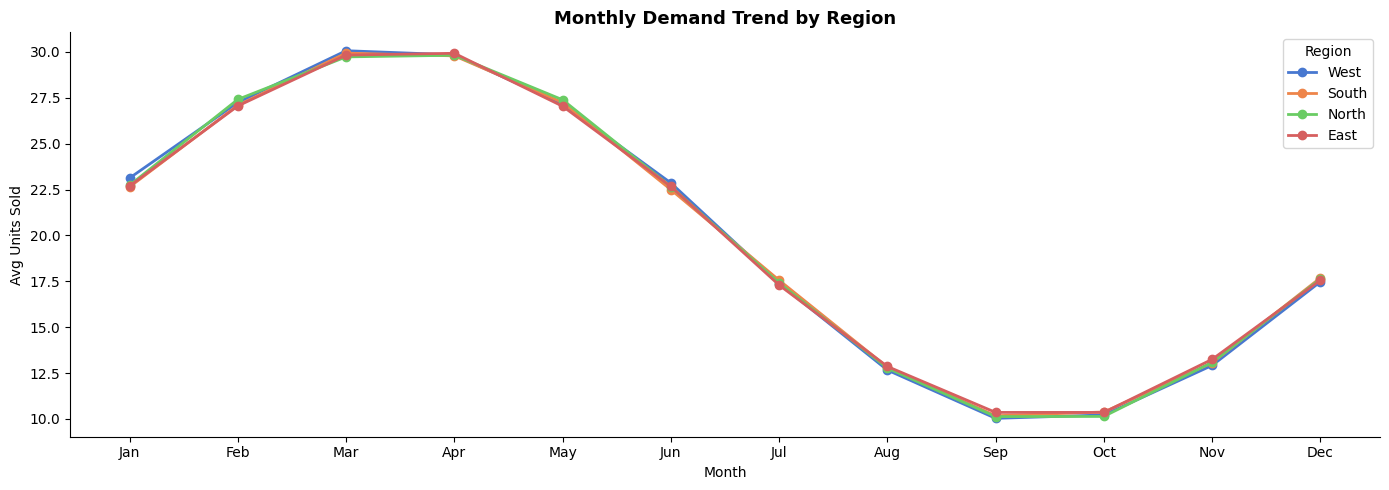

In [9]:
# Monthly demand trend per Region
region_monthly = df.groupby(['Month_Name', 'Region'])['Units_Sold'].mean().reset_index()
month_order    = ['Jan','Feb','Mar','Apr','May','Jun',
                  'Jul','Aug','Sep','Oct','Nov','Dec']
region_monthly['Month_Name'] = pd.Categorical(region_monthly['Month_Name'],
                                               categories=month_order, ordered=True)
region_monthly = region_monthly.sort_values('Month_Name')

fig, ax = plt.subplots(figsize=(14, 5))
for region in region_monthly['Region'].unique():
    data = region_monthly[region_monthly['Region'] == region]
    ax.plot(data['Month_Name'], data['Units_Sold'], marker='o', linewidth=2, label=region)

ax.set_title('Monthly Demand Trend by Region')
ax.set_xlabel('Month')
ax.set_ylabel('Avg Units Sold')
ax.legend(title='Region')
plt.tight_layout()
plt.show()

---
## 🎯 Section 6: Promotion Impact Analysis

In [10]:
# ─────────────────────────────────────────────────────────────
# SECTION 6: PROMOTION IMPACT ANALYSIS
# ─────────────────────────────────────────────────────────────

promo_stats = df.groupby('Promotion_Flag')['Units_Sold'].agg(['mean','median','std','count'])
promo_stats.index = ['No Promotion', 'Promotion Active']
promo_stats.columns = ['Mean', 'Median', 'Std Dev', 'Count']

print('── Promotion Impact Summary ──')
print(promo_stats.round(2))
lift = ((promo_stats.loc['Promotion Active','Mean'] - promo_stats.loc['No Promotion','Mean'])
         / promo_stats.loc['No Promotion','Mean'] * 100)
print(f'\n  📈 Promotion Demand Lift : +{lift:.1f}% average uplift in Units Sold')

── Promotion Impact Summary ──
                  Mean  Median  Std Dev  Count
No Promotion     19.50   20.00     8.61  81980
Promotion Active 24.91   24.00    11.31   9270

  📈 Promotion Demand Lift : +27.7% average uplift in Units Sold


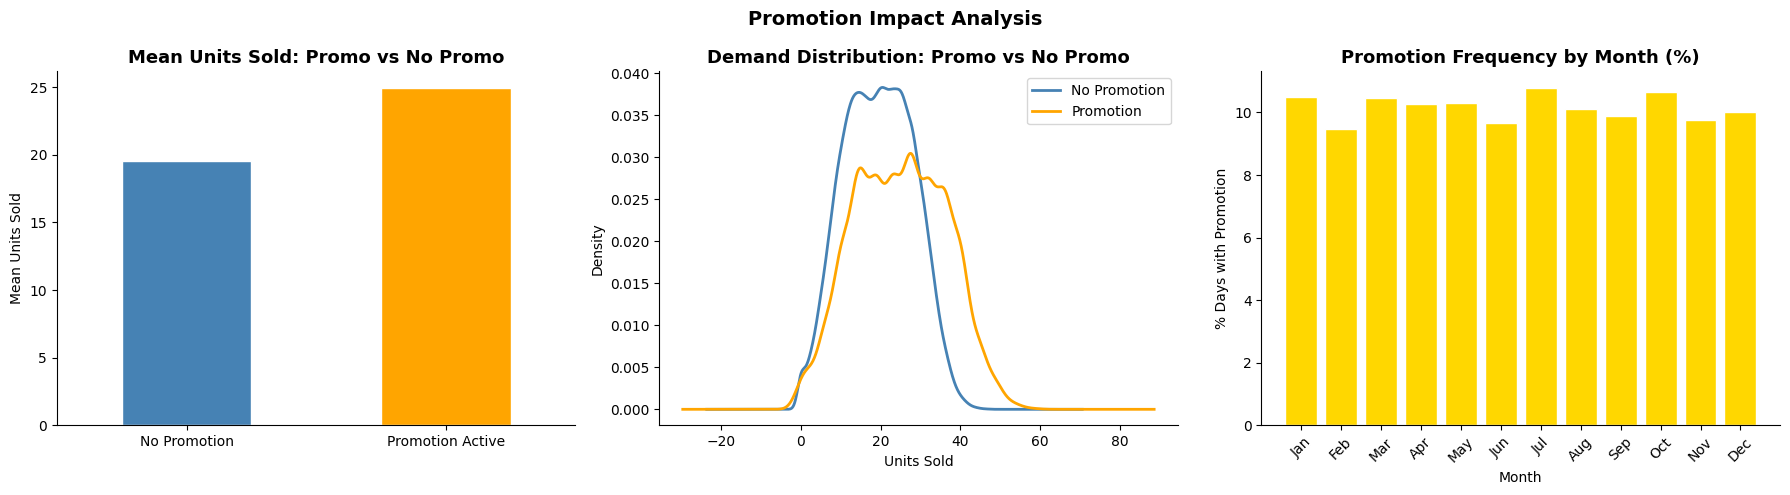

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Mean demand comparison
promo_stats['Mean'].plot(kind='bar', ax=axes[0], color=['steelblue','orange'], edgecolor='white')
axes[0].set_title('Mean Units Sold: Promo vs No Promo')
axes[0].set_ylabel('Mean Units Sold')
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', rotation=0)

# Distribution comparison
df[df['Promotion_Flag']==0]['Units_Sold'].plot(
    kind='kde', ax=axes[1], color='steelblue', label='No Promotion', linewidth=2)
df[df['Promotion_Flag']==1]['Units_Sold'].plot(
    kind='kde', ax=axes[1], color='orange', label='Promotion', linewidth=2)
axes[1].set_title('Demand Distribution: Promo vs No Promo')
axes[1].set_xlabel('Units Sold')
axes[1].legend()

# Promotion frequency by month
promo_monthly = df.groupby('Month_Name')['Promotion_Flag'].mean().reindex(month_order) * 100
axes[2].bar(promo_monthly.index, promo_monthly.values, color='gold', edgecolor='white')
axes[2].set_title('Promotion Frequency by Month (%)')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('% Days with Promotion')
axes[2].tick_params(axis='x', rotation=45)

plt.suptitle('Promotion Impact Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## ⚠️ Section 7: Stockout Analysis

In [12]:
# ─────────────────────────────────────────────────────────────
# SECTION 7: STOCKOUT ANALYSIS
# ─────────────────────────────────────────────────────────────

stockout_rate_overall = df['Stockout_Flag'].mean() * 100
print(f'  Overall Stockout Rate : {stockout_rate_overall:.2f}%')
print()

# Stockout rate by SKU
sku_stockout = df.groupby('SKU_ID')['Stockout_Flag'].mean().sort_values(ascending=False) * 100
print('── Top 10 SKUs with Highest Stockout Rate ──')
print(sku_stockout.head(10).round(2))

  Overall Stockout Rate : 0.00%

── Top 10 SKUs with Highest Stockout Rate ──
SKU_ID
SKU_1    0.00
SKU_43   0.00
SKU_34   0.00
SKU_35   0.00
SKU_36   0.00
SKU_37   0.00
SKU_38   0.00
SKU_39   0.00
SKU_4    0.00
SKU_40   0.00
Name: Stockout_Flag, dtype: float64


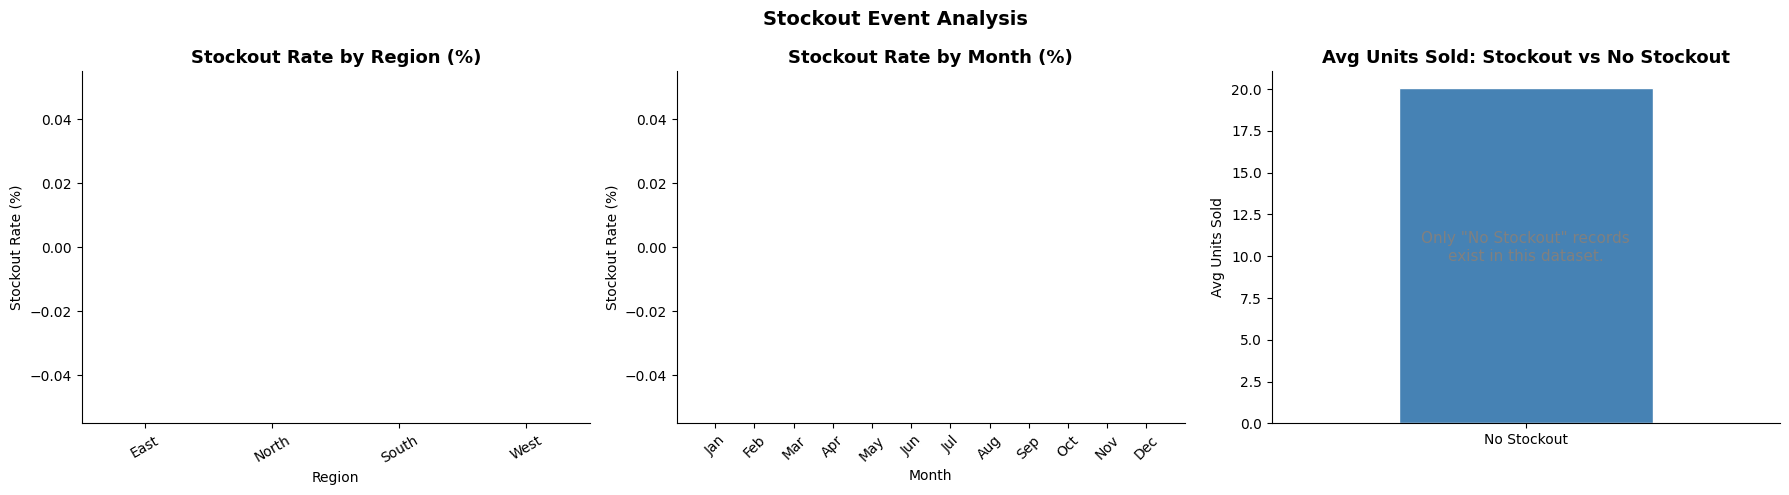

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Stockout rate by Region
region_stockout = df.groupby('Region')['Stockout_Flag'].mean() * 100
region_stockout.sort_values(ascending=False).plot(
    kind='bar', ax=axes[0], color='salmon', edgecolor='white')
axes[0].set_title('Stockout Rate by Region (%)')
axes[0].set_xlabel('Region')
axes[0].set_ylabel('Stockout Rate (%)')
axes[0].tick_params(axis='x', rotation=30)

# Stockout rate by Month
monthly_stockout = df.groupby('Month_Name')['Stockout_Flag'].mean().reindex(month_order) * 100
axes[1].bar(monthly_stockout.index, monthly_stockout.values, color='firebrick', edgecolor='white')
axes[1].set_title('Stockout Rate by Month (%)')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Stockout Rate (%)')
axes[1].tick_params(axis='x', rotation=45)

# ── FIXED: Safe label assignment for Stockout vs No Stockout ──
stockout_sales = df.groupby('Stockout_Flag')['Units_Sold'].mean()

# Build label map based on what values actually exist in the data
label_map = {0: 'No Stockout', 1: 'Stockout'}
stockout_sales.index = [label_map.get(i, str(i)) for i in stockout_sales.index]

bar_colors = []
for label in stockout_sales.index:
    if label == 'No Stockout':
        bar_colors.append('steelblue')
    else:
        bar_colors.append('firebrick')

stockout_sales.plot(kind='bar', ax=axes[2], color=bar_colors, edgecolor='white')
axes[2].set_title('Avg Units Sold: Stockout vs No Stockout')
axes[2].set_ylabel('Avg Units Sold')
axes[2].set_xlabel('')
axes[2].tick_params(axis='x', rotation=0)

# Annotate if only one class exists
if len(stockout_sales) == 1:
    axes[2].text(0.5, 0.5,
                 f'Only "{stockout_sales.index[0]}" records\nexist in this dataset.',
                 ha='center', va='center', transform=axes[2].transAxes,
                 fontsize=11, color='grey')

plt.suptitle('Stockout Event Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


---
## 🚚 Section 8: Supplier & Lead Time Analysis

In [14]:
# ─────────────────────────────────────────────────────────────
# SECTION 8: SUPPLIER & LEAD TIME ANALYSIS
# ─────────────────────────────────────────────────────────────

supplier_stats = df.groupby('Supplier_ID').agg(
    Avg_Lead_Time  = ('Supplier_Lead_Time_Days', 'mean'),
    Std_Lead_Time  = ('Supplier_Lead_Time_Days', 'std'),
    Stockout_Rate  = ('Stockout_Flag', 'mean'),
    Total_Units    = ('Units_Sold', 'sum')
).round(3)
supplier_stats['Stockout_Rate'] = (supplier_stats['Stockout_Rate'] * 100).round(2)

print('── Supplier Performance Summary ──')
print(supplier_stats.sort_values('Stockout_Rate', ascending=False))
print()
print(f'  Overall Avg Lead Time : {df["Supplier_Lead_Time_Days"].mean():.1f} days')
print(f'  Lead Time Range       : {df["Supplier_Lead_Time_Days"].min()} – {df["Supplier_Lead_Time_Days"].max()} days')

── Supplier Performance Summary ──
             Avg_Lead_Time  Std_Lead_Time  Stockout_Rate  Total_Units
Supplier_ID                                                          
SUP_1                 8.11           3.57           0.00       204249
SUP_10                7.41           3.79           0.00       197242
SUP_2                 8.42           4.09           0.00       190999
SUP_3                 8.26           4.02           0.00       168017
SUP_4                 8.64           3.26           0.00       183147
SUP_5                 6.96           3.42           0.00       168145
SUP_6                 7.90           3.56           0.00       146684
SUP_7                 7.56           4.51           0.00       248830
SUP_8                 8.50           4.21           0.00       205407
SUP_9                 8.19           3.76           0.00       117259

  Overall Avg Lead Time : 8.0 days
  Lead Time Range       : 2 – 14 days


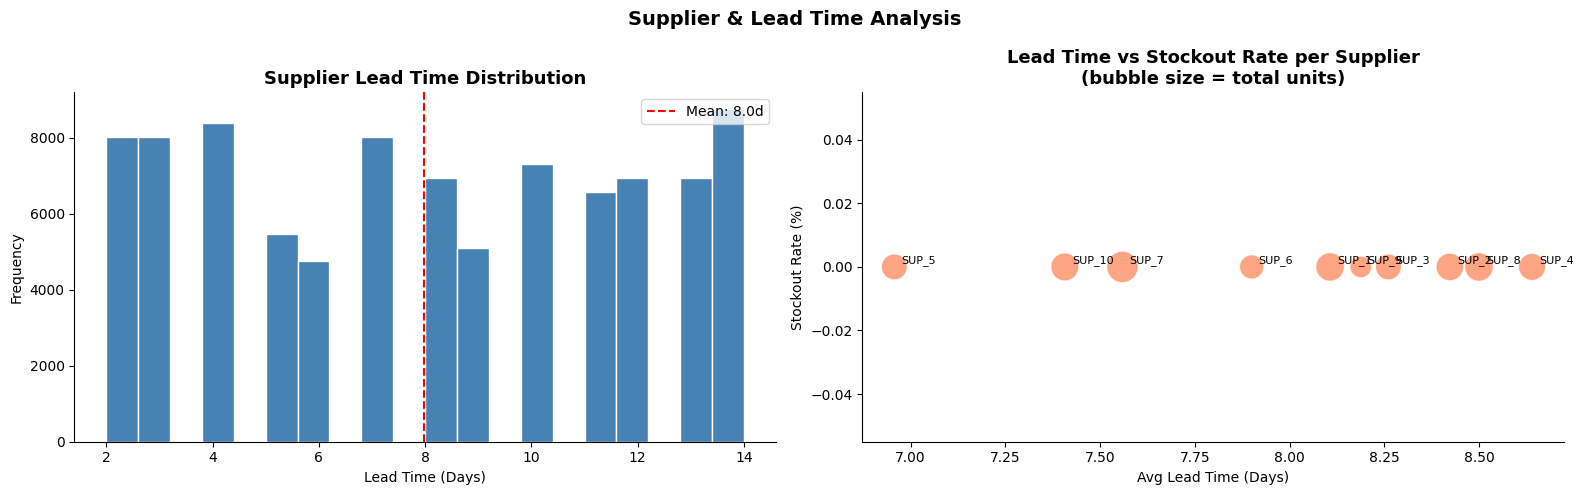

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Lead time distribution
axes[0].hist(df['Supplier_Lead_Time_Days'], bins=20, color='steelblue', edgecolor='white')
axes[0].axvline(df['Supplier_Lead_Time_Days'].mean(), color='red', linestyle='--',
                linewidth=1.5, label=f'Mean: {df["Supplier_Lead_Time_Days"].mean():.1f}d')
axes[0].set_title('Supplier Lead Time Distribution')
axes[0].set_xlabel('Lead Time (Days)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Avg Lead Time vs Stockout Rate per Supplier
scatter = axes[1].scatter(
    supplier_stats['Avg_Lead_Time'],
    supplier_stats['Stockout_Rate'],
    s=supplier_stats['Total_Units']/supplier_stats['Total_Units'].max()*500,
    alpha=0.7, color='coral', edgecolors='white', linewidths=0.5)
for idx, row in supplier_stats.iterrows():
    axes[1].annotate(idx, (row['Avg_Lead_Time'], row['Stockout_Rate']),
                     textcoords='offset points', xytext=(5,3), fontsize=8)
axes[1].set_title('Lead Time vs Stockout Rate per Supplier\n(bubble size = total units)')
axes[1].set_xlabel('Avg Lead Time (Days)')
axes[1].set_ylabel('Stockout Rate (%)')

plt.suptitle('Supplier & Lead Time Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 🏭 Section 9: Inventory Level Analysis

In [16]:
# ─────────────────────────────────────────────────────────────
# SECTION 9: INVENTORY LEVEL ANALYSIS
# ─────────────────────────────────────────────────────────────

print('── Inventory Level Summary ──')
print(df['Inventory_Level'].describe())

# Inventory Health Classification
# Below Reorder Point = At Risk
df['Inventory_Status'] = np.where(
    df['Inventory_Level'] <= 0, 'Critical (Zero Stock)',
    np.where(df['Inventory_Level'] <= df['Reorder_Point'], 'At Risk (Below ROP)',
             'Healthy (Above ROP)')
)

status_dist = df['Inventory_Status'].value_counts()
print()
print('── Inventory Health Distribution ──')
print(status_dist)
print()
print(f'  % At Risk or Critical : {((status_dist.get("At Risk (Below ROP)",0) + status_dist.get("Critical (Zero Stock)",0)) / len(df) * 100):.1f}%')

── Inventory Level Summary ──
count   91250.00
mean      471.52
std       133.49
min       168.00
25%       370.00
50%       461.00
75%       564.00
max       990.00
Name: Inventory_Level, dtype: float64

── Inventory Health Distribution ──
Inventory_Status
Healthy (Above ROP)    86209
At Risk (Below ROP)     5041
Name: count, dtype: int64

  % At Risk or Critical : 5.5%


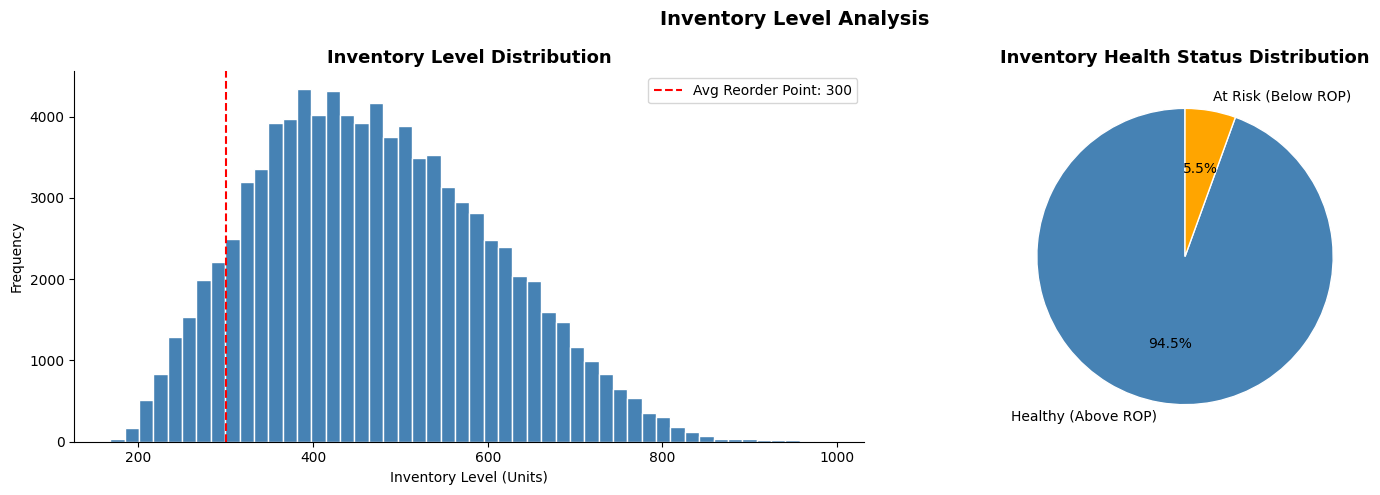

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Inventory Level distribution
axes[0].hist(df['Inventory_Level'], bins=50, color='steelblue', edgecolor='white')
axes[0].axvline(df['Reorder_Point'].mean(), color='red', linestyle='--',
                linewidth=1.5, label=f'Avg Reorder Point: {df["Reorder_Point"].mean():.0f}')
axes[0].set_title('Inventory Level Distribution')
axes[0].set_xlabel('Inventory Level (Units)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Inventory Health Pie
colors_status = {'Healthy (Above ROP)': 'steelblue',
                 'At Risk (Below ROP)': 'orange',
                 'Critical (Zero Stock)': 'firebrick'}
pie_colors = [colors_status.get(s, 'grey') for s in status_dist.index]
axes[1].pie(status_dist, labels=status_dist.index, autopct='%1.1f%%',
            colors=pie_colors, startangle=90,
            wedgeprops={'edgecolor': 'white'})
axes[1].set_title('Inventory Health Status Distribution')

plt.suptitle('Inventory Level Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

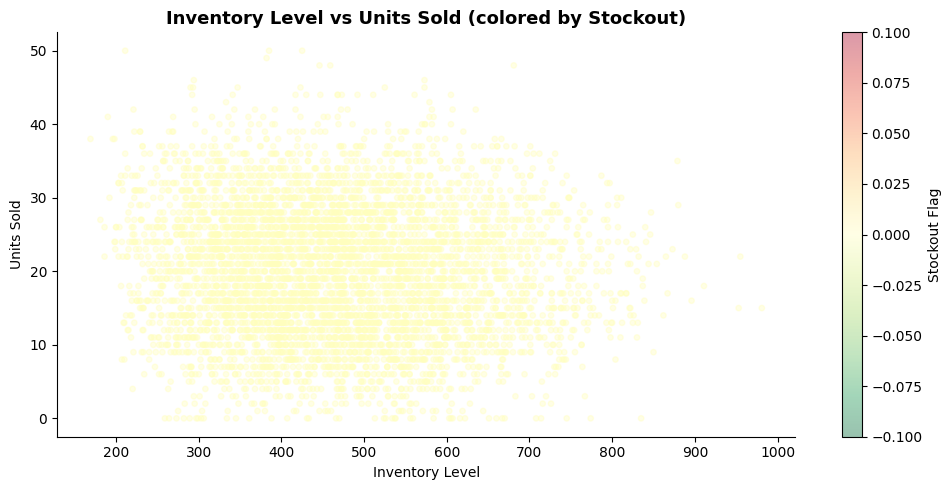

In [18]:
# Inventory vs Demand scatter (sample for speed)
sample = df.sample(min(5000, len(df)), random_state=42)

fig, ax = plt.subplots(figsize=(10, 5))
scatter = ax.scatter(sample['Inventory_Level'], sample['Units_Sold'],
                     c=sample['Stockout_Flag'], cmap='RdYlGn_r',
                     alpha=0.4, s=15)
ax.set_title('Inventory Level vs Units Sold (colored by Stockout)')
ax.set_xlabel('Inventory Level')
ax.set_ylabel('Units Sold')
plt.colorbar(scatter, ax=ax, label='Stockout Flag')
plt.tight_layout()
plt.show()

---
## 🎯 Section 10: Baseline Forecast Quality Check

In [19]:
# ─────────────────────────────────────────────────────────────
# SECTION 10: BASELINE FORECAST QUALITY
# This is critical — we measure how good the existing
# Demand_Forecast column is, so our model has a benchmark to beat.
# ─────────────────────────────────────────────────────────────

from sklearn.metrics import mean_absolute_error, mean_squared_error

y_true     = df['Units_Sold']
y_baseline = df['Demand_Forecast']

baseline_mae  = mean_absolute_error(y_true, y_baseline)
baseline_rmse = np.sqrt(mean_squared_error(y_true, y_baseline))
baseline_mape = np.mean(np.abs((y_true - y_baseline) / y_true.replace(0, np.nan))) * 100
baseline_r2   = 1 - (np.sum((y_true - y_baseline)**2) / np.sum((y_true - y_true.mean())**2))

print('── Baseline Forecast (Demand_Forecast column) Performance ──')
print(f'  MAE   : {baseline_mae:.3f}   (Mean Absolute Error)')
print(f'  RMSE  : {baseline_rmse:.3f}   (Root Mean Squared Error)')
print(f'  MAPE  : {baseline_mape:.2f}%  (Mean Absolute Percentage Error)')
print(f'  R²    : {baseline_r2:.4f}  (Coefficient of Determination)')
print()
print('  📌 These are our BENCHMARK values.')
print('  📌 Our Hybrid LSTM+XGBoost model must outperform all four metrics.')

── Baseline Forecast (Demand_Forecast column) Performance ──
  MAE   : 2.380   (Mean Absolute Error)
  RMSE  : 2.987   (Root Mean Squared Error)
  MAPE  : 16.32%  (Mean Absolute Percentage Error)
  R²    : 0.8915  (Coefficient of Determination)

  📌 These are our BENCHMARK values.
  📌 Our Hybrid LSTM+XGBoost model must outperform all four metrics.


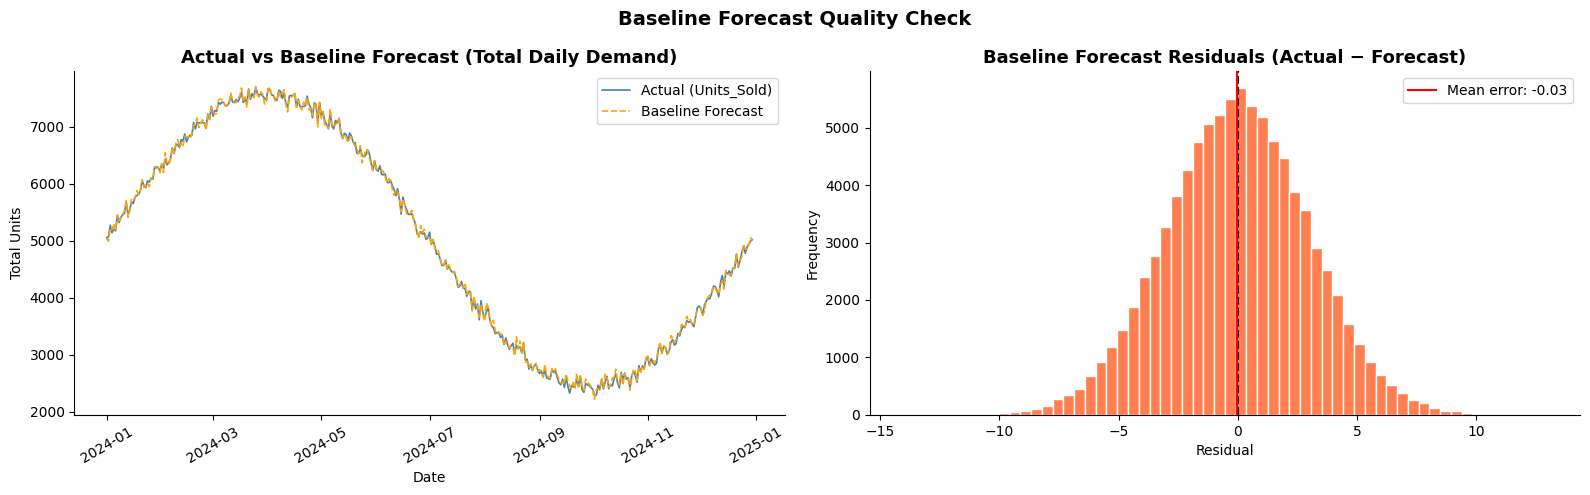

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Actual vs Baseline Forecast — sample
sample_dates = df.groupby('Date')['Units_Sold'].sum()
sample_fore  = df.groupby('Date')['Demand_Forecast'].sum()

axes[0].plot(sample_dates.index, sample_dates.values,
             label='Actual (Units_Sold)', color='steelblue', linewidth=1.2)
axes[0].plot(sample_fore.index, sample_fore.values,
             label='Baseline Forecast', color='orange', linewidth=1.2, linestyle='--')
axes[0].set_title('Actual vs Baseline Forecast (Total Daily Demand)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Total Units')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=30)

# Residuals distribution
residuals = y_true - y_baseline
axes[1].hist(residuals, bins=60, color='coral', edgecolor='white')
axes[1].axvline(0, color='black', linewidth=1.5, linestyle='--')
axes[1].axvline(residuals.mean(), color='red', linewidth=1.5,
                label=f'Mean error: {residuals.mean():.2f}')
axes[1].set_title('Baseline Forecast Residuals (Actual − Forecast)')
axes[1].set_xlabel('Residual')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.suptitle('Baseline Forecast Quality Check', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 🔥 Section 11: Correlation Heatmap

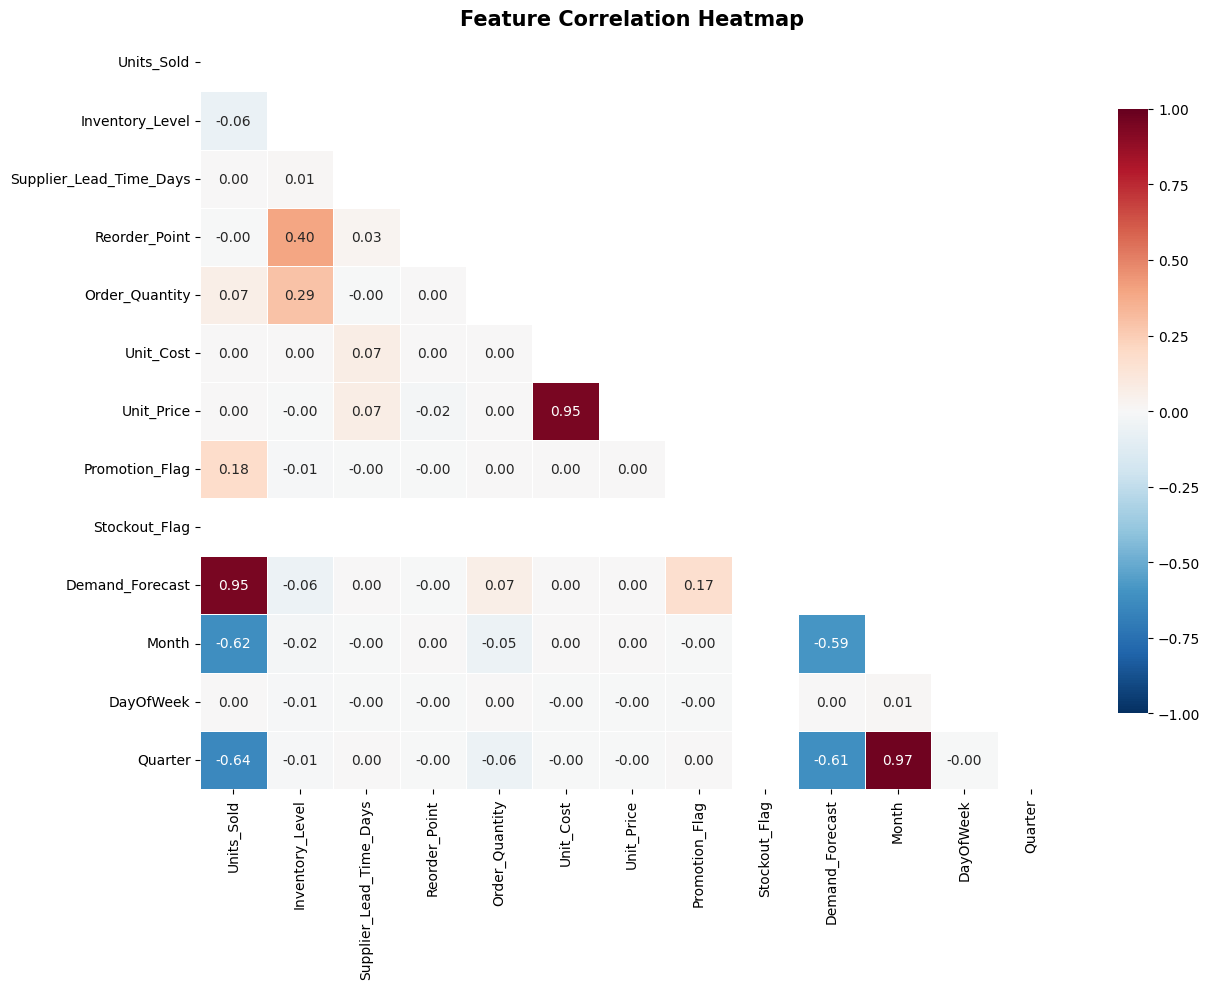

── Top Feature Correlations with Units_Sold ──
  Demand_Forecast                : +0.949
  Quarter                        : -0.642
  Month                          : -0.623
  Promotion_Flag                 : +0.180
  Order_Quantity                 : +0.069
  Inventory_Level                : -0.064
  Unit_Cost                      : +0.002
  Reorder_Point                  : -0.002
  Unit_Price                     : +0.001
  DayOfWeek                      : +0.001
  Supplier_Lead_Time_Days        : +0.001
  Stockout_Flag                  : -nan


In [21]:
# ─────────────────────────────────────────────────────────────
# SECTION 11: CORRELATION HEATMAP
# ─────────────────────────────────────────────────────────────

numeric_cols = ['Units_Sold', 'Inventory_Level', 'Supplier_Lead_Time_Days',
                'Reorder_Point', 'Order_Quantity', 'Unit_Cost', 'Unit_Price',
                'Promotion_Flag', 'Stockout_Flag', 'Demand_Forecast',
                'Month', 'DayOfWeek', 'Quarter']

corr_matrix = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(13, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='RdBu_r', center=0, vmin=-1, vmax=1,
            linewidths=0.5, ax=ax,
            cbar_kws={'shrink': 0.8})
ax.set_title('Feature Correlation Heatmap', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

# Print top correlations with Units_Sold
units_corr = corr_matrix['Units_Sold'].drop('Units_Sold').abs().sort_values(ascending=False)
print('── Top Feature Correlations with Units_Sold ──')
for feat, val in units_corr.items():
    direction = '+' if corr_matrix.loc[feat,'Units_Sold'] > 0 else '-'
    print(f'  {feat:<30} : {direction}{val:.3f}')

---
## 💡 Section 12: Key Findings Summary

In [22]:
# ─────────────────────────────────────────────────────────────
# SECTION 12: AUTO-GENERATED KEY FINDINGS
# ─────────────────────────────────────────────────────────────

top_region      = region_demand.idxmax()
worst_stockout_sku = sku_stockout.idxmax()
promo_lift_val  = lift
high_cv_skus    = (sku_stats['CV'] > 0.5).sum()

print('=' * 60)
print('  📊  EDA KEY FINDINGS SUMMARY')
print('=' * 60)
print(f'  1. Dataset covers {df["Date"].min().date()} to {df["Date"].max().date()}')
print(f'     across {df["SKU_ID"].nunique()} SKUs, {df["Warehouse_ID"].nunique()} warehouses, {df["Region"].nunique()} regions.')
print()
print(f'  2. Demand Seasonality: Clear monthly/quarterly variation detected.')
print(f'     Highest demand region: {top_region}')
print()
print(f'  3. {high_cv_skus} SKUs have high demand volatility (CV > 0.5).')
print(f'     These are critical targets for accurate forecasting.')
print()
print(f'  4. Promotions drive +{promo_lift_val:.1f}% uplift in avg Units Sold.')
print(f'     Promotion_Flag is a key feature for XGBoost.')
print()
print(f'  5. Overall Stockout Rate: {stockout_rate_overall:.2f}%')
print(f'     Worst SKU: {worst_stockout_sku} ({sku_stockout.max():.1f}% stockout rate)')
print()
print(f'  6. Baseline Forecast (Demand_Forecast column):')
print(f'     MAE={baseline_mae:.3f} | RMSE={baseline_rmse:.3f} | MAPE={baseline_mape:.2f}% | R²={baseline_r2:.4f}')
print(f'     → Our Hybrid Model target: beat all 4 metrics.')
print()
print(f'  7. Demand_Forecast is most correlated feature with Units_Sold.')
print(f'     Inventory_Level and Promotion_Flag are next — strong feature candidates.')
print('=' * 60)

  📊  EDA KEY FINDINGS SUMMARY
  1. Dataset covers 2024-01-01 to 2024-12-30
     across 50 SKUs, 5 warehouses, 4 regions.

  2. Demand Seasonality: Clear monthly/quarterly variation detected.
     Highest demand region: East

  3. 0 SKUs have high demand volatility (CV > 0.5).
     These are critical targets for accurate forecasting.

  4. Promotions drive +27.7% uplift in avg Units Sold.
     Promotion_Flag is a key feature for XGBoost.

  5. Overall Stockout Rate: 0.00%
     Worst SKU: SKU_1 (0.0% stockout rate)

  6. Baseline Forecast (Demand_Forecast column):
     MAE=2.380 | RMSE=2.987 | MAPE=16.32% | R²=0.8915
     → Our Hybrid Model target: beat all 4 metrics.

  7. Demand_Forecast is most correlated feature with Units_Sold.
     Inventory_Level and Promotion_Flag are next — strong feature candidates.


In [23]:
# Save enriched df with time columns for feature engineering notebook
df.drop(columns=['Month_Name', 'DayName', 'Inventory_Status'], inplace=True, errors='ignore')
df.to_csv('supply_chain_eda_ready.csv', index=False)

print('✅ EDA-enriched dataset saved: supply_chain_eda_ready.csv')
print('   ➡️  Proceed to Notebook 03: Feature Engineering')

✅ EDA-enriched dataset saved: supply_chain_eda_ready.csv
   ➡️  Proceed to Notebook 03: Feature Engineering


---
## ✅ Notebook 02 Summary

| Analysis | Status |
|---|---|
| Overall Demand Trend | ✅ |
| Seasonality (Month, DOW, Quarter, Heatmap) | ✅ |
| SKU-Level Demand & Volatility | ✅ |
| Regional & Warehouse Analysis | ✅ |
| Promotion Impact (+lift%) | ✅ |
| Stockout Analysis | ✅ |
| Supplier & Lead Time Analysis | ✅ |
| Inventory Health Analysis | ✅ |
| Baseline Forecast Benchmark | ✅ |
| Correlation Heatmap | ✅ |
| Key Findings Auto-Summary | ✅ |
| Output Saved | ✅ `supply_chain_eda_ready.csv` |

**➡️ Proceed to Notebook 03: Feature Engineering**

---
*Intelligent Supply Chain Optimization System | Notebook 02 of 08*